In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder


In [23]:
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersNumber", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [24]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [25]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [26]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [27]:
works = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus"], axis=1)[df["Circulant"] == 0]

temp = works['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
works['unproportionality_coeficient'] = temp[temp.columns[1]]/temp[temp.columns[0]]
works['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
works.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [28]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')

workc['unproportionality_coeficient'] = np.ones([temp.shape[0], 1])
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [29]:
work = pd.concat([works, workc])

del works
del workc


Data ready

<Axes: >

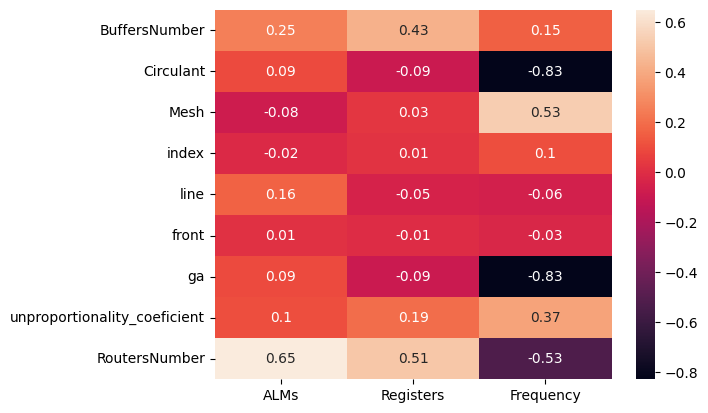

In [40]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "ga", "index", "line", "front", "BuffersNumber", "unproportionality_coeficient", "RoutersNumber"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error


In [32]:
X = work.drop(["Registers"] ,axis=1)
y = work[["Registers"]]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

root_mean_squared_error(y_test, lr.predict(X_test))


/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


6839.421970577772

In [35]:
print(work.drop(["Registers"], axis=1).columns)
lr.coef_

Index(['BuffersNumber', 'ALMs', 'Frequency', 'Circulant', 'Mesh', 'index',
       'line', 'front', 'ga', 'unproportionality_coeficient', 'RoutersNumber'],
      dtype='object')


array([[ 4.64294427e+02,  1.38091002e+00,  1.88658937e+02,
         4.06940877e+02, -1.46611790e+03, -7.16373958e+03,
        -1.83013015e+04, -7.18483171e+02,  4.06940877e+02,
         2.20850865e+03,  2.78286418e+01]])

In [36]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [37]:
model = smf.ols(formula='Registers ~ Mesh + index + line + front + RoutersNumber*BuffersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.711e+04
Date:                 Вт, 11 мар 2025   Prob (F-statistic):               0.00
Time:                        16:21:52   Log-Likelihood:                -43325.
No. Observations:                4429   AIC:                         8.667e+04
Df Residuals:                    4420   BIC:                         8.673e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [38]:
model = smf.ols(formula='ALMs ~ Mesh + index + line + front +  RoutersNumber*BuffersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                 Вт, 11 мар 2025   Prob (F-statistic):               0.00
Time:                        16:21:52   Log-Likelihood:                -44489.
No. Observations:                4429   AIC:                         8.900e+04
Df Residuals:                    4420   BIC:                         8.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [39]:
model = smf.ols(formula='Frequency ~ index + ALMs + Registers + RoutersNumber*BuffersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     765.3
Date:                 Вт, 11 мар 2025   Prob (F-statistic):               0.00
Time:                        16:21:53   Log-Likelihood:                -17761.
No. Observations:                4429   AIC:                         3.554e+04
Df Residuals:                    4421   BIC:                         3.559e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       